# Packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import harmonypy as hm
from modules.visualize import *
from modules.deg_analysis import *

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-25 10:01:08.645181: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 10:01:09.204038: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import dataset and annotation

In [2]:
sample_tag_mapping = {'SampleTag17_flex':'WT-DMSO',
                      'SampleTag18_flex':'3xTg-DMSO',
                      'SampleTag19_flex':'WT-SCDi',
                      'SampleTag20_flex':'3xTg-SCDi',
                      'Undetermined':'Undetermined',
                      'Multiplet':'Multiplet'}
adata = anndata.read_h5ad("data/fede_count.h5ad")
adata.obs['Sample_Tag'] = adata.obs['Sample_Tag'].map(sample_tag_mapping)
anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)

In [3]:
# adata1 = anndata.read_h5ad("data/A_count.h5ad")
# adata1.obs['Sample_Tag'] = 'LD_5xFAD'
# adata2 = anndata.read_h5ad("data/B_count.h5ad")
# adata2.obs['Sample_Tag'] = "LD_NC"
# adata3 = anndata.read_h5ad("data/C_count.h5ad")
# adata3.obs['Sample_Tag'] = "run_5xFAD"
# adata4 = anndata.read_h5ad("data/D_count.h5ad")
# adata4.obs['Sample_Tag'] = "run_NC"
# adata = anndata.concat([adata1, adata2, adata3, adata4], axis=0)

# anno_df1 = pd.read_csv("data/A_mapping.csv", skiprows=4)
# anno_df2 = pd.read_csv("data/B_mapping.csv", skiprows=4)
# anno_df3 = pd.read_csv("data/C_mapping.csv", skiprows=4)
# anno_df4 = pd.read_csv("data/D_mapping.csv", skiprows=4)
# anno_df = pd.concat([anno_df1, anno_df2, anno_df3, anno_df4])

In [4]:
adata = annotate_adata(adata, anno_df)

# Data preprocessing

In [5]:
sc.pp.filter_cells(adata, min_genes=150)
sc.pp.filter_genes(adata, min_cells=3)

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.obs['high_mt'] = adata.obs['pct_counts_mt'] > 50

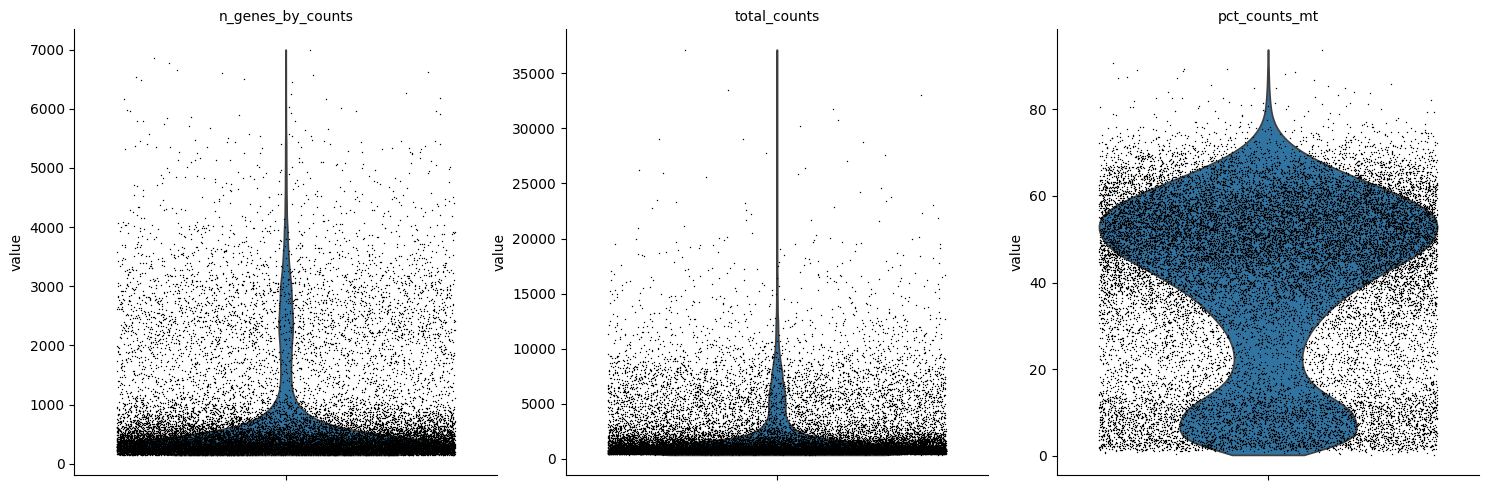

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True, save='violin.png')

In [8]:
adata = adata[~adata.obs['high_mt'], :]
adata = adata[adata.obs['Sample_Name'] != "Multiplet", :]

In [10]:
adata = adata[:, ~adata.var['mt']]

# Select adata object to use for analysis

In [12]:
file_path = 'data/filtered_adata.h5ad'
adata = anndata.read_h5ad(file_path)

In [13]:
adata.raw = adata

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
sc.pp.scale(adata)

# Dimensionality reduction

In [ ]:
elbow_plot(adata, save_path='figures/elbow_plot.png')

In [ ]:
dimension_heatmap(adata, n_components=20, n_cells=500, save_path='figures/dimension_heatmap.png')

In [ ]:
sc.tl.pca(adata, n_comps=6)

# Batch correction

In [ ]:
harmony_out = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'Sample_Tag')
adata.obsm['X_pca_harmony'] = harmony_out.Z_corr.T

# Clustering

In [ ]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_pcs=6)
sc.tl.leiden(adata, resolution=0.5)

# Visualization

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=['leiden'], save='_leiden.png')
sc.pl.umap(adata, color=['Sample_Tag'], save='_sample_tag.png')
#sc.pl.umap(adata, color=['high_mt'], save='_high_mt.png')

# Cluster annotation

In [ ]:
assign_unique_cell_type_names(adata, cluster_key='leiden', cluster_types=['class_name', 'subclass_name'])

# Cluster visualization

In [ ]:
sc.pl.umap(adata, color=['cluster_class_name'], save='_cluster_anno.png', title=f'After QC - {adata.shape[0]} cells', size=10)

In [ ]:
sc.pl.umap(adata, color=['cluster_subclass_name'], save='_subcluster_anno.png', title=f'After QC - {adata.shape[0]} cells', size=10)

In [ ]:
plot_umap(adata, cluster_type='cluster_subclass_name', legend_fontsize=7, save_path='_sample_tag')

# Keep only a specific cell type

In [ ]:
filtered_obs = adata.obs[adata.obs['cluster_class_name'].str.startswith('Astro-Epen')]
filtered_indices = adata.obs.index.get_indexer(filtered_obs.index)
filtered_adata = anndata.AnnData(
    X=adata.raw.X[filtered_indices, :],
    obs=filtered_obs.copy(),
    var=adata.raw.var.copy(),
)
file_path = 'data/filtered_adata.h5ad'
filtered_adata.write_h5ad(file_path)

# Master table

In [ ]:
sample_tag_counts = get_master_table(adata, cluster_type='cluster_class_name', save_path='master_table.pkl')

# Clusters composition analysis

In [ ]:
class_level, cluster_type = 'subclass_name', 'cluster_subclass_name'

In [ ]:
#create_ditto_plot(adata, ['WT-DMSO', '3xTg-DMSO', 'WT-SCDi', '3xTg-SCDi', 'Undetermined'], class_level=class_level, cluster_type=cluster_type, min_cell=100)
create_ditto_plot(adata, ['WT-DMSO'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/wt_dmso_ditto.png')
create_ditto_plot(adata, ['3xTg-DMSO'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/3xtg_dmso_ditto.png')
create_ditto_plot(adata, ['WT-SCDi'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/wt_scdi_ditto.png')
create_ditto_plot(adata, ['3xTg-SCDi'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/3xtg_scdi_ditto.png')
create_ditto_plot(adata, ['Undetermined'], class_level=class_level, cluster_type=cluster_type, min_cell=100, save_path='figures/undetermined_ditto.png')

# DEG analysis

In [ ]:
cell_types = [x for x in set(adata.obs.cluster_class_name.values)]

In [ ]:
#ctr, cnd = 'WT-DMSO', '3xTg-DMSO'
#ctr, cnd = 'WT-DMSO', 'WT-SCDi'
ctr, cnd = 'WT-DMSO', '3xTg-SCDi'
#ctr, cnd = '3xTg-DMSO', '3xTg-SCDi'

In [ ]:
horizontal_deg_chart(adata, 
                     cell_types,
                     ctr, 
                     cnd, 
                     min_fold_change=0.25, 
                     max_p_value=0.05, 
                     fig_title=f'{ctr} vs {cnd}',
                     save_path=f'figures/{ctr}_{cnd}_horizontal_deg_chart.png')

In [ ]:
results_df = DEG_analysis(adata, 
                          ctr, 
                          cnd, 
                          cell_types, 
                          save_path=f'figures/{ctr}_{cnd}_results_df.pkl')

In [ ]:
volcano_plot(results_df, 
             min_fold_change=0.25, 
             max_p_value=0.05, 
             fig_title=f'{ctr} vs {cnd}',
             save_path=f'figures/{ctr}_{cnd}_volcano_plot.png')

# Retrieve NCBI gene list

In [ ]:
#genes_ncbi = query_genes(adata.raw, save_path='data/genes_ncbi.pkl')

In [ ]:
genes_ncbi = pickle.load(open('data/genes_ncbi.pkl', 'rb'))

# GO term enrichment analysis

In [ ]:
UP_genes_id, DOWN_genes_id, UP_genes_name, DOWN_genes_name = get_DEGs(results_df, 
                                                                      genes_ncbi, 
                                                                      max_pval=0.05, 
                                                                      min_fold_change=0.25)

In [ ]:
UP_GO = go_enrichment_analysis(UP_genes_id, genes_ncbi.values(), save_path=f'figures/{ctr}_{cnd}_GO_enrichment_analysis_UP.pkl')
DOWN_GO = go_enrichment_analysis(DOWN_genes_id, genes_ncbi.values(), save_path=f'figures/{ctr}_{cnd}_GO_enrichment_analysis_DOWN.pkl')

In [ ]:
display_go_enrichment(UP_GO, 
                      namespace='BP',
                      fig_title=f'UP BP - {ctr} vs {cnd}',
                      save_path=f'figures/{ctr}_{cnd}_display_GO_enrichment_UP')

display_go_enrichment(UP_GO, 
                      namespace='MF',
                      fig_title=f'UP MF - {ctr} vs {cnd}',
                      save_path=f'figures/{ctr}_{cnd}_display_GO_enrichment_UP')

display_go_enrichment(UP_GO, 
                      namespace='CC',
                      fig_title=f'UP CC - {ctr} vs {cnd}',
                      save_path=f'figures/{ctr}_{cnd}_display_GO_enrichment_UP')

In [ ]:
display_go_enrichment(DOWN_GO, 
                      namespace='BP',
                      fig_title=f'DOWN BP - {ctr} vs {cnd}',
                      save_path=f'figures/{ctr}_{cnd}_display_GO_enrichment_DOWN_BP')

display_go_enrichment(DOWN_GO, 
                      namespace='MF',
                      fig_title=f'DOWN MF - {ctr} vs {cnd}',
                      save_path=f'figures/{ctr}_{cnd}_display_GO_enrichment_DOWN_MF')

display_go_enrichment(DOWN_GO, 
                      namespace='CC',
                      fig_title=f'DOWN CC - {ctr} vs {cnd}',
                      save_path=f'figures/{ctr}_{cnd}_display_GO_enrichment_DOWN_CC')

In [ ]:
UP_KEGG = kegg_enrichment_analysis(UP_genes_name, 
                                   save_path=f'figures/{ctr}_{cnd}_KEGG_enrichment_analysis.pkl')

In [ ]:
DOWN_KEGG = kegg_enrichment_analysis(DOWN_genes_name, 
                                     save_path=f'figures/{ctr}_{cnd}_KEGG_enrichment_analysis.pkl')

In [ ]:
display_kegg_enrichment(UP_KEGG,
                        fig_title=f'UP pathway - {ctr} vs {cnd}',
                        save_path=f'figures/{ctr}_{cnd}_display_KEGG_enrichment_UP')

In [ ]:
display_kegg_enrichment(DOWN_KEGG,
                        fig_title=f'DOWN pathway - {ctr} vs {cnd}',
                        save_path=f'figures/{ctr}_{cnd}_display_KEGG_enrichment_DOWN')